In [1]:
#Dylan Kearns 16385613

import pandas as pd
import numpy as np
import collections
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [2]:
test_data = pd.read_csv('SPECTF_test.csv')
train_data = pd.read_csv('SPECTF_train.csv')

In [3]:
train_data.head(2)

,DIAGNOSIS,F1R,F1S,F2R,F2S,F3R,F3S,F4R,F4S,F5R,...,F18R,F18S,F19R,F19S,F20R,F20S,F21R,F21S,F22R,F22S
0,1,59,52,70,67,73,66,72,61,58,...,66,56,62,56,72,62,74,74,64,67
1,1,72,62,69,67,78,82,74,65,69,...,65,71,63,60,69,73,67,71,56,58


In [4]:
y = train_data.pop('DIAGNOSIS').values
X = train_data.values

In [5]:
gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X,y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [6]:
train_score = cross_val_score(gb_classifier, X, y, cv=4)
print("4x CV Accuracy GB: {0:.2f}".format(train_score.mean()))
train_score

4x CV Accuracy GB: 0.80


array([0.65, 0.8 , 0.8 , 0.95])

In [7]:
y_test_data = test_data.pop('DIAGNOSIS').values
X_test_data = test_data.values
y_predicted = gb_classifier.predict(X_test_data)


In [8]:
accuracy = accuracy_score(y_test_data,y_predicted)
print(accuracy)

0.7219251336898396


In [9]:
data = {'Train Accuracy':[train_score.mean()], 'Test Accuracy' :[accuracy]}
df = pd.DataFrame(data) 

## Info gain

In [10]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

In [11]:
mi = dict()

i_scores = mutual_info_classif(X, y)

for i,j in zip(train_data.columns,i_scores):
    mi[i]=j

df1 = pd.DataFrame.from_dict(mi,orient='index',columns=['I-Gain'])
df1.sort_values(by=['I-Gain'],ascending=False,inplace=True)

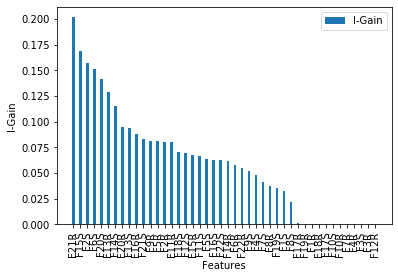

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

n = len(df1.index)
rr = range(1,n)
fig, ax = plt.subplots()
ax.bar(df1.index, df1["I-Gain"], label='I-Gain',width=.35)
ax.set_xticklabels(list(df1.index), rotation = 90)
ax.set_xlabel('Features')
ax.set_ylabel('I-Gain')
ax.legend()

plt.show()

In [13]:
acc_scores = []
for kk in range(1, X.shape[1]+1):
    FS_trans = SelectKBest(mutual_info_classif, 
                           k=kk).fit(X, y)
    X_tR_new = FS_trans.transform(X)
    X_tS_new = FS_trans.transform(X_test_data)
    gb_train = gb_classifier.fit(X_tR_new, y)
    y_dash = gb_train.predict(X_tS_new)
    acc = accuracy_score(y_test_data, y_dash)
    acc_scores.append(acc)

df1['Accuracy'] = acc_scores
df1.head(15)

,I-Gain,Accuracy
F21R,0.201767,0.641711
F15S,0.169330,0.647059
F2S,0.156893,0.732620
F6S,0.151614,0.679144
F20S,0.141514,0.732620
F13R,0.129475,0.737968
F14S,0.115057,0.721925
F20R,0.095185,0.754011
F13S,0.093900,0.721925
F16R,0.088208,0.775401


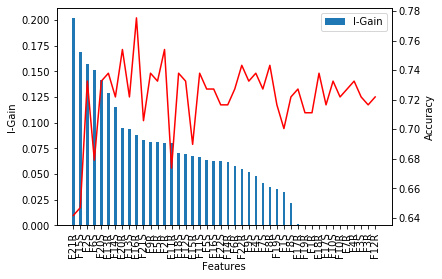

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

n = len(df1.index)
rr = range(1,n)
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.bar(df1.index, df1["I-Gain"], label='I-Gain',width=.35)
ax2.plot(df1.index, df1["Accuracy"], color='red', label='Accuracy')
ax.set_xticklabels(list(df1.index), rotation = 90)
ax.set_xlabel('Features')
ax.set_ylabel('I-Gain')
ax2.set_ylabel('Accuracy')
ax.legend()

plt.show()

In [15]:
#this function finds the max point of accuracy in the features and then puts all the features before it into a list
top_n = list()
for index,row in df1.iterrows():
    if row['Accuracy'] == max(acc_scores):
        top_n.append(index)
        break
    else:
        top_n.append(index)

In [16]:
top_n_df_train = train_data[top_n]

In [17]:
top_n_df_train.head(3)

,F21R,F15S,F2S,F6S,F20S,F13R,F14S,F20R,F13S,F16R
0,74,54,67,71,62,63,54,72,64,76
1,67,69,67,70,73,74,70,69,69,72
2,61,59,64,71,55,53,68,64,37,72


In [18]:
X_info_gain = top_n_df_train.values
gb_classifier.fit(X_info_gain,y)

info_gain_train_score = cross_val_score(gb_classifier, X_info_gain, y, cv=5)
print("4x CV Accuracy GB info gain: {0:.2f}".format(info_gain_train_score.mean()))

4x CV Accuracy GB info gain: 0.78


## Info gain with test data

In [19]:
X_test_data2 = test_data[top_n].values

In [20]:
y_predicted = gb_classifier.predict(X_test_data2)

In [21]:
accuracy = accuracy_score(y_test_data,y_predicted)
print(accuracy)

0.7165775401069518


In [22]:
data = {'Train Accuracy':[info_gain_train_score.mean()], 'Test Accuracy' :[accuracy]}
df_ig = pd.DataFrame(data) 
df_ig

,Train Accuracy,Test Accuracy
0,0.775,0.716578


## Forward sequential search

In [23]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [24]:
#I've selected 10 features to save on computation time, I am aware you can set it to 'best' and it will return the subsets it
# deems to be the best without any limit
sfs_forward = SFS(gb_classifier, 
                  k_features=10, 
                  forward=True, 
                  floating=False, 
                  verbose=1,
                  scoring='accuracy',
                  cv=4, n_jobs = -1)

sfs_forward = sfs_forward.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    6.1s finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    4.3s finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    4.4s finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    3.9s finished
Features: 4/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.8s finished
Features: 5/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    3.8s finished
Features: 6/10[Parallel(n_jobs=-1)]: Using backe

In [25]:
print('Selected features:', sfs_forward.k_feature_idx_)
selected_features = sfs_forward.k_feature_idx_

Selected features: (4, 8, 16, 17, 21, 23, 29, 33, 36, 37)


In [26]:
selected_features = np.asarray(selected_features)

In [27]:
X_test_data1 = test_data.iloc[ : , selected_features].values
X_sfs =  train_data.iloc[ : , selected_features].values

In [28]:
gb_classifier.fit(X_sfs, y)
gbc_score_train_sfs = cross_val_score(gb_classifier, X_sfs, y, cv=4)
print("4x CV Accuracy gbc on train data: {0:.2f}".format(gbc_score_train_sfs.mean()))

4x CV Accuracy gbc on train data: 0.89


In [29]:
y_predicted = gb_classifier.predict(X_test_data1)
accuracy = accuracy_score(y_test_data,y_predicted)
print(accuracy)

0.6631016042780749


In [30]:
data = {'Train Accuracy':[gbc_score_train_sfs.mean()], 'Test Accuracy' :[accuracy]}
df_sfs = pd.DataFrame(data) 
df_sfs

,Train Accuracy,Test Accuracy
0,0.8875,0.663102


## Backwards elimination

In [31]:
sbs = SFS(gb_classifier, 
          k_features=10, 
          forward=False, 
          floating=False, 
          scoring='accuracy',
          cv=4,
          n_jobs=-1)
sbs = sbs.fit(X, y)

In [32]:
print(sbs.k_feature_idx_)
selected_features_2 = sbs.k_feature_idx_
selected_features_2 = np.asarray(selected_features_2)

(0, 1, 2, 4, 8, 9, 11, 25, 29, 39)


In [33]:
X_test_data_sbs = test_data.iloc[ : , selected_features_2].values
X_sbs = train_data.iloc[ : , selected_features_2].values

In [34]:
gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_sbs, y)
gbc_score_train_sbs = cross_val_score(gb_classifier, X_sbs, y, cv=4)
print("4x CV Accuracy gbc on train data: {0:.2f}".format(gbc_score_train_sbs.mean()))

4x CV Accuracy gbc on train data: 0.87


In [35]:
y_predicted = gb_classifier.predict(X_test_data_sbs)
accuracy = accuracy_score(y_test_data,y_predicted)
print(accuracy)

0.7272727272727273


In [36]:
data = {'Train Accuracy':[(gbc_score_train_sbs.mean())], 'Test Accuracy' :[accuracy]}
df_sbs = pd.DataFrame(data) 
df_sbs

,Train Accuracy,Test Accuracy
0,0.875,0.727273


In [37]:
pdList = [df, df_ig, df_sfs, df_sbs] 

In [38]:
full_df = pd.concat(pdList)

In [39]:
full_df

,Train Accuracy,Test Accuracy
0,0.8000,0.721925
0,0.7750,0.716578
0,0.8875,0.663102
0,0.8750,0.727273


In [40]:
subsets = ['none', 'info-gain', 'sfs', 'sbs' ]
full_df['Type'] = subsets
full_df = full_df.reset_index(drop=True)

In [41]:
full_df

,Train Accuracy,Test Accuracy,Type
0,0.8000,0.721925,none
1,0.7750,0.716578,info-gain
2,0.8875,0.663102,sfs
3,0.8750,0.727273,sbs


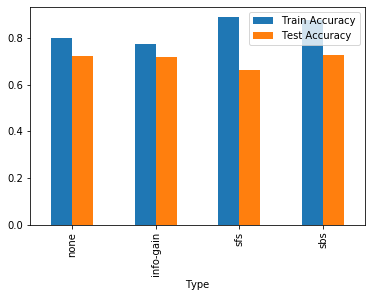

In [42]:
full_df.plot(x="Type", y=["Train Accuracy", "Test Accuracy"], kind="bar")

In [43]:
collections.Counter(y_test_data)

Counter({1: 172, 0: 15})

# Analysis
* Looking at the results when no feature subset selection was used we see that it consistently has a train accuracy of around 0.76-0.78 every run and a test accuracy of 0.70-.72. The test accuracy is good considering 90% of the test data DIAGNOSIS values are 1.

* Using the information gain filter we see that the values of the training and test set tend to fluctuate quite a bit and aren't very consistent. The reason for this incosistency could be due to the fact that different features might suit our classifier better but information gain does not take this into account. Also the features are considered in isolation from one another so there might be certain features in our data where it needs another feature to boost the accuracy. 

* The sequential forward searching algorithm always has a better training accuracy than the training accuracy with no feature subset selection. That being said the test accuracy fluctuates a lot. Sometimes it is worse than no subset selection and sometimes it is better. What seems to be happening is the wrapper is finding the best feature subset for the training data but this feature subset doesn't always work well for the test data.

* Backwards elimination, like sequential forward searching, always has a better training accuracy than when no feature subsets are selected. However the algorithm is consistently better on the test data in comparison to SBS and also it generally has a better test accuracy than when no feature subsets are selected. 